# Modelling Formula 1 Outcomes for Fantasy EV Projections

F1 Fantasy is well-suited to optimisation when compared to other fantasy sports. The problem space is relatively small - a team consists of only 5 assets, chosen from a pool of 30. You can also change half of your assets each race without a penalty, so planning more than 1 week ahead is almost always unneccesary. This makes for a much easier challenge than e.g. FPL optimisation, where we are choosing 15 assets from hundreds in a multi-period problem. Many drivers are either far too expenisve to be viable at their price point or sufficiently inexpensive to make them essential. Marginal decisions exist, but are less common than in other fantasy sports, which makes modelling it quite forgiving. 

In [ ]:
!pip install unidecode
!pip install gurobipy
!pip install pulp

     |████████████████████████████████| 235 kB 5.2 MB/s 
     |████████████████████████████████| 11.5 MB 4.4 MB/s 
     |████████████████████████████████| 14.2 MB 3.9 MB/s 


In [ ]:
import numpy as np
import pandas as pd
from itertools import product

import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
from sklearn.linear_model import LinearRegression
import gurobipy as gp
from pulp import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To play Formula 1 Fantasy optimally, we split our process into two parts: predicting outcomes from which we can develop expected value projections, and using these projections to optimize our team. 

First, we need to model a probability distribution of outcomes (i.e. the likelihood of each outcome to occur to each driver). We are deriving estimates for the probability of these outcomes from odds.

## Converting Odds into Implied Probabilities

The first step is to collect our odds. I use the shortest decimal odds available (i.e. highest decimal) across spread markets and traditional bookmakers.

The relevant markets are winner, podium finish, top 6 finish, points finish, fastest lap, and to finish unclassified.

In [ ]:
#df = pd.read_csv('https://raw.githubusercontent.com/harryrgrove/F1_model/master/odds_input.csv', index_col=0)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/odds_input_2022.csv', index_col=0)

df

,team,winner,top3,top6,top10,flap,dnf
driver,,,,,,,
Hamilton,Mercedes,10.00,8.00,1.22,1.15,3.25,6.50
Verstappen,Red Bull,1.58,1.32,1.20,1.15,2.63,6.00
Russell,Mercedes,20.00,18.00,14.00,3.00,7.00,5.00
Perez,Red Bull,6.00,5.00,1.32,1.21,6.00,6.00
Ricciardo,McLaren,3000.00,200.00,100.00,10.00,41.00,5.50
Leclerc,Ferrari,2.00,1.90,1.45,1.25,19.00,5.00
Vettel,Aston Martin,1001.00,500.00,66.00,10.00,251.00,5.00
Alonso,Alpine,300.00,34.00,15.00,1.62,251.00,5.50
Sainz,Ferrari,3.00,2.50,1.56,1.33,34.00,6.00


The basic implied probability from these projections can be obtained by finding their multiplicative inverse:

In [ ]:
odds_cols = ['winner', 'top3', 'top6', 'top10', 'flap', 'dnf']
for col in odds_cols:
    df[col] **= -1
df

,team,winner,top3,top6,top10,flap,dnf
driver,,,,,,,
Hamilton,Mercedes,0.100000,0.125000,0.819672,0.869565,0.307692,0.153846
Verstappen,Red Bull,0.632911,0.757576,0.833333,0.869565,0.380228,0.166667
Russell,Mercedes,0.050000,0.055556,0.071429,0.333333,0.142857,0.200000
Perez,Red Bull,0.166667,0.200000,0.757576,0.826446,0.166667,0.166667
Ricciardo,McLaren,0.000333,0.005000,0.010000,0.100000,0.024390,0.181818
Leclerc,Ferrari,0.500000,0.526316,0.689655,0.800000,0.052632,0.200000
Vettel,Aston Martin,0.000999,0.002000,0.015152,0.100000,0.003984,0.200000
Alonso,Alpine,0.003333,0.029412,0.066667,0.617284,0.003984,0.181818
Sainz,Ferrari,0.333333,0.400000,0.641026,0.751880,0.029412,0.166667


Probabilities implied directly odds are never optimal to begin with because they are overrounded. There are many ways to adjust for this, as explained in this paper: http://article.sciencepublishinggroup.com/pdf/10.11648.j.ajss.20170506.12.pdf

We will be using the "power" adjustment method favoured by the paper's authors. For example, if we want a column of probabilities to add to 1 (e.g. for race winner, since there can be only 1 winner), then we must raise each probability $p_i$ to the same exponent $k$, such that the sum of the probabilities raised to $k$ equals the desired total $T$, i.e. we want $k$ such that $\sum_{i=1}^{20}p_i^k=T$

In [ ]:
def adjust_odds(odds_series, target_sum, method='power'):
    if method == 'power':
        def f(x):
            return sum([i**x for i in odds_series]) - target_sum
        k = optimize.fsolve(f, 1) # optimise k such that the sum of p_i^k - T = 0
        return odds_series ** k
    elif method == 'linear':
        return odds_series / sum(odds_series) * target_sum

We want the winner column to add to 1, the top 3 column to add to 3, etc.

In [ ]:
for col, target in zip(odds_cols[:-1], [1, 3, 6, 10, 1]):
    df[col] = adjust_odds(df[col], target)
df

,team,winner,top3,top6,top10,flap,dnf
driver,,,,,,,
Hamilton,Mercedes,0.020113,0.189865,0.855886,0.894565,0.272704,0.153846
Verstappen,Red Bull,0.460229,0.801057,0.867029,0.894565,0.344377,0.166667
Russell,Mercedes,0.006205,0.099325,0.126782,0.416525,0.117044,0.200000
Perez,Red Bull,0.047846,0.276397,0.804712,0.859021,0.138725,0.166667
Ricciardo,McLaren,0.000001,0.014505,0.027216,0.159516,0.016674,0.181818
Leclerc,Ferrari,0.308529,0.598798,0.747680,0.837035,0.038930,0.200000
Vettel,Aston Martin,0.000008,0.006975,0.037675,0.159516,0.002262,0.200000
Alonso,Alpine,0.000063,0.059755,0.120118,0.680731,0.002262,0.181818
Sainz,Ferrari,0.155079,0.480897,0.706095,0.796647,0.020496,0.166667


We also need to adjust our DNF odds, since currently they may show a driver's DNF probability and top 10 probability to add to more than 1, which is of course impossible.

We can adjust these under the assumption that given a top driver finishes the race, they are 96% likely to finish in the top 10:

In [ ]:
df['dnf'] **= (np.log(0.96 - df['top10']) / np.log(df['dnf'])).max()
df['winner'] = df[['winner', 'top3']].min(axis=1)
df

,team,winner,top3,top6,top10,flap,dnf
driver,,,,,,,
Hamilton,Mercedes,0.020113,0.189865,0.855886,0.894565,0.272704,0.057931
Verstappen,Red Bull,0.460229,0.801057,0.867029,0.894565,0.344377,0.065435
Russell,Mercedes,0.006205,0.099325,0.126782,0.416525,0.117044,0.086359
Perez,Red Bull,0.047846,0.276397,0.804712,0.859021,0.138725,0.065435
Ricciardo,McLaren,0.000001,0.014505,0.027216,0.159516,0.016674,0.074699
Leclerc,Ferrari,0.308529,0.598798,0.747680,0.837035,0.038930,0.086359
Vettel,Aston Martin,0.000008,0.006975,0.037675,0.159516,0.002262,0.086359
Alonso,Alpine,0.000063,0.059755,0.120118,0.680731,0.002262,0.074699
Sainz,Ferrari,0.155079,0.480897,0.706095,0.796647,0.020496,0.065435


## Estimating Race Finishing Position Distributions

After adjusting our odds, we can move on to looking at the probability distributions they imply. 

If we assume the probabilities are as uniform as the odds could possibly imply, this is what the implied distribution looks like for Pierre Gasly:

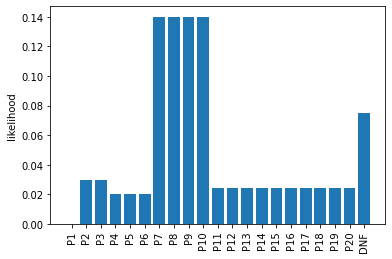

In [ ]:
def get_probs(idx):
    probs = [df.loc[idx, 'winner']]
    probs += [(df.loc[idx, 'top3'] - df.loc[idx, 'winner'])/2] * 2
    probs += [(df.loc[idx, 'top6'] - df.loc[idx, 'top3']) / 3] * 3
    probs += [(df.loc[idx, 'top10'] - df.loc[idx, 'top6']) / 4] * 4
    probs += [(1 - df.loc[idx, 'top10'] - df.loc[idx, 'dnf']) / 10] * 10
    probs.append(df.loc[idx, 'dnf'])
    return probs

driver = 'Alonso'

plt.bar(['P{}'.format(i) for i in range(1, 21)] + ['DNF'], get_probs(driver))
plt.xticks(rotation=90)
plt.ylabel('likelihood')
plt.show()

If we wanted, we could calculate expected value projections using these uniform distributions, and this would work fine. To improve them slightly (and also for the sake of fun), we want them to resemble a bell-curve. An easy way to do this is to minimize the squared difference between the implied probabilities of consecutive finishes, which can be done with quadratic optimisation.

In other words, for each driver we need to solve the following optimisation problem, given $p_i$ is the probability a driver finishes in position $i$:

$$\text{Minimise} \ \sum_{i=1}^{19} (p_{i+1} - p_i)^2$$

$$\text{Subject to: } \ p_1 = P(\text{win}); \ \ \sum_{i=1}^3 p_i = P(\text{podium finish}); \ \ \sum_{i=1}^6 p_i = P(\text{top 6 finish}); \\ \sum_{i=1}^{10} p_i = P(\text{points finish}); \ \ \sum_{i=11}^{20} p_i = 1 - P(\text{points finish}) - P(\text{dnf}).$$

Let's first demonstrate on Gasly's probability distribution:

Restricted license - for non-production use only - expires 2023-10-25


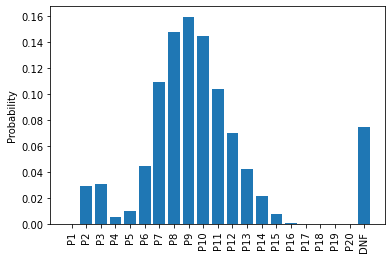

In [ ]:
quadratic_model = gp.Model('quadratic')
quadratic_model.setParam('outputFlag', False)
driver = 'Alonso'
# Add the probability of finishing in each position as a model variable
x = {i: quadratic_model.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, ub=1, name=f'x_{i}') for i in range(1, 21)}
# Set objective to minimize the differences between probabilities of consecutive positions
obj = sum([(x[i] - x[i + 1])**2 for i in range(1, 20)])
quadratic_model.setObjective(obj, gp.GRB.MINIMIZE)
# Set model constraints
quadratic_model.addConstr(x[1] == df.loc[driver, 'winner'])
quadratic_model.addConstr(x[2] + x[3] == df.loc[driver, 'top3'] - df.loc[driver, 'winner'])
quadratic_model.addConstr(x[4] + x[5] + x[6] == df.loc[driver, 'top6'] - df.loc[driver, 'top3'])
quadratic_model.addConstr(x[7] + x[8] + x[9] + x[10] == df.loc[driver, 'top10'] - df.loc[driver, 'top6'])
quadratic_model.addConstr(sum([x[i] for i in range(11, 21)]) == 1 - df.loc[driver, 'top10'] - df.loc[driver, 'dnf'])
if df.loc[driver, 'top10'] >= 0.5:
    quadratic_model.addConstr(x[20] == 0)
# Optimize model parameters
quadratic_model.optimize()
vals = [v.x for v in quadratic_model.getVars()]
plt.bar(['P{}'.format(i) for i in range(1, 21)] + ['DNF'], vals + [df.loc[driver, 'dnf']])
plt.xticks(rotation=90)
plt.ylabel('Probability')
plt.show()

Much more satisfying! Now we can apply this method to all other drivers:

In [ ]:
pos_dict = {}

for driver in df.index:
    print(driver)
    quadratic_model = gp.Model('quadratic')
    quadratic_model.setParam('outputFlag', False)
    x = {i: quadratic_model.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, ub=1, name=f'x_{i}') for i in range(1, 21)}
    obj = sum([(x[i] - x[i + 1])**2 for i in range(1, 20)])
    quadratic_model.setObjective(obj, gp.GRB.MINIMIZE)
    quadratic_model.addConstr(x[1] == df.loc[driver, 'winner'])
    quadratic_model.addConstr(x[2] + x[3] == df.loc[driver, 'top3'] - df.loc[driver, 'winner'])
    quadratic_model.addConstr(x[4] + x[5] + x[6] == df.loc[driver, 'top6'] - df.loc[driver, 'top3'])
    quadratic_model.addConstr(x[7] + x[8] + x[9] + x[10] == df.loc[driver, 'top10'] - df.loc[driver, 'top6'])
    quadratic_model.addConstr(sum([x[i] for i in range(11, 21)]) == 1 - df.loc[driver, 'top10'] - df.loc[driver, 'dnf'])
    quadratic_model.optimize()
    print(quadratic_model.getVars())
    pos_dict[driver] = {i + 1: v.x for i, v in enumerate(quadratic_model.getVars())}

Hamilton
[<gurobi.Var x_1 (value 0.020113089089085573)>, <gurobi.Var x_2 (value 0.05024084756025555)>, <gurobi.Var x_3 (value 0.11951110745870369)>, <gurobi.Var x_4 (value 0.22792386878713458)>, <gurobi.Var x_5 (value 0.25058943031255226)>, <gurobi.Var x_6 (value 0.18750779203504944)>, <gurobi.Var x_7 (value 0.03867895395430831)>, <gurobi.Var x_8 (value 3.96407275370348e-12)>, <gurobi.Var x_9 (value 2.129928831589363e-12)>, <gurobi.Var x_10 (value 2.139659174524093e-12)>, <gurobi.Var x_11 (value 0.001233875730070933)>, <gurobi.Var x_12 (value 0.002344363920564603)>, <gurobi.Var x_13 (value 0.0033314647601507172)>, <gurobi.Var x_14 (value 0.0041951782339469095)>, <gurobi.Var x_15 (value 0.004935504350198394)>, <gurobi.Var x_16 (value 0.005552443098707747)>, <gurobi.Var x_17 (value 0.006045994479176173)>, <gurobi.Var x_18 (value 0.006416158445163914)>, <gurobi.Var x_19 (value 0.006662934939322499)>, <gurobi.Var x_20 (value 0.0067863236494919025)>]
Verstappen
[<gurobi.Var x_1 (value 0.460

We can store this information in a DataFrame $\texttt{pos_df}$, alongside other essential information such as mean projected position.

In [ ]:
pos_df = pd.DataFrame(pos_dict).T
pos_df['dnf'] = df.dnf
pos_df['team'] = df.team
pos_df['mean_pos'] = sum([i / (1 - df['dnf']) * pos_df[i] for i in range(1, 21)])
pos_df.head(10).T

,Hamilton,Verstappen,Russell,Perez,Ricciardo,Leclerc,Vettel,Alonso,Sainz,Stroll
1,0.020113,0.460229,0.006205,0.047846,0.000001,0.308529,0.000008,0.000063,0.155079,0.000004
2,0.050241,0.238868,0.045432,0.090658,0.006859,0.184757,0.002388,0.028944,0.17088,0.008854
3,0.119511,0.10196,0.047687,0.137893,0.007645,0.105512,0.00458,0.030748,0.154937,0.009299
4,0.227924,0.049506,0.01297,0.189552,0.002359,0.070793,0.006585,0.005477,0.10725,0.001338
5,0.250589,0.015756,0.001428,0.192381,0.002446,0.046239,0.009822,0.010142,0.07119,0.005509
6,0.187508,0.00071,0.013059,0.146381,0.007906,0.03185,0.014293,0.044744,0.046758,0.021814
7,0.038679,0.004367,0.047864,0.051551,0.018738,0.027627,0.019996,0.109281,0.033954,0.050252
8,0.0,0.006837,0.071615,0.002758,0.028806,0.023822,0.026463,0.147445,0.024305,0.069961
9,0.0,0.008119,0.084311,0.0,0.038109,0.020437,0.033694,0.159235,0.017814,0.080941
10,0.0,0.008212,0.085953,0.0,0.046648,0.01747,0.041689,0.144652,0.014479,0.083191


We can also create another DataFrame $\texttt{ev_df}$, which will store all the expected value of all sources of points, such as race position, dnf penalty, etc.

In [ ]:
ev_df = pd.DataFrame(index=df.index)
ev_df['race'] = 25 * pos_df[1] + 18 * pos_df[2] + 15 * pos_df[3] \
                 + 12 * pos_df[4] + 10 * pos_df[5] + 8 * pos_df[6] \
                 + 6 * pos_df[7] + 4 * pos_df[8] + 2 * pos_df[9] \
                 + pos_df[10] + (1 - pos_df['dnf']) * 1
ev_df['flap'] = df['flap'] * 5
ev_df['dnf'] = -15 * df['dnf']

ev_df.head()

,race,flap,dnf
driver,,,
Hamilton,11.115015,1.363521,-0.868960
Verstappen,19.104632,1.721886,-0.981524
Russell,3.704475,0.585222,-1.295385
Perez,11.520791,0.693624,-0.981524
Ricciardo,1.629998,0.083370,-1.120488


## Modelling Sources of Points outside of Odds

Next, we must estimate the value of other sources of points based on these race position distributions.

There is little/no market data on these categories, so we can attempt to infer the distributions from past data analysis of players with similar race end expectations (i.e. running a linear regression to formulate expectations, then building probability distributions from this expectation matrix). First we need to collect data, which I've already stored in csv files for race data and result data.

In [ ]:
race_df = pd.read_csv("https://raw.githubusercontent.com/harryrgrove/F1_model/master/races.csv")
result_df = pd.read_csv("https://raw.githubusercontent.com/harryrgrove/F1_model/master/results.csv")

In [ ]:
# Gather IDs of all races
race_dict = {}
for year in range(2015, 2022):
    races = race_df[race_df['year']==year]['raceId'].tolist()
    race_dict[year] = races

# We are interested in how mean race position predicts mean grid position, mean fantasy points from quali, 
# % of Q2 finishes, % of Q3 finishes, and mean number of positions gained.
values = {'grid': [], 'position': [], 'fantasy': [], 'top10': [], 'top15': [], 'mean_gain': []}

# Iterate through the result data to collect these data points for each driver who raced more than 15
# times in a season since 2015
for year in race_dict:
    season_df = result_df[result_df['raceId'].isin(race_dict[year])]
    drivers = season_df['driverId'].unique()
    for driver in drivers:
        driver_df = season_df[season_df['driverId']==driver]
        grid_pos_df = driver_df[['grid', 'position']][driver_df['position'].str.isnumeric() & (driver_df['grid'] != 0)]
        grid_pos_df['grid'] = grid_pos_df['grid'].astype(float)
        grid_pos_df['position'] = grid_pos_df['position'].astype(float)
        
        if len(grid_pos_df) > 15:
            values['grid'].append(grid_pos_df['grid'].mean())
            values['position'].append(grid_pos_df['position'].mean())
            values['fantasy'].append(sum([sum(grid_pos_df['grid']==i) * 
                                          (11 - i) for i in range(1, 11)]) / len(grid_pos_df))
            values['top10'].append(sum(grid_pos_df['grid'] <= 10) / len(grid_pos_df))
            values['top15'].append(sum(grid_pos_df['grid'] <= 15) / len(grid_pos_df))

            total = 0
            for idx in grid_pos_df.index:
                if grid_pos_df.loc[idx, 'grid'] - grid_pos_df.loc[idx, 'position'] > 0:
                    total += min(10, (grid_pos_df.loc[idx, 'grid'] - grid_pos_df.loc[idx, 'position']) * 2)
                elif grid_pos_df.loc[idx, 'grid'] - grid_pos_df.loc[idx, 'position'] < 0:
                    if grid_pos_df.loc[idx, 'grid'] <= 10:
                        total += max(-10, (grid_pos_df.loc[idx, 'grid'] - grid_pos_df.loc[idx, 'position']) * 2)
                    else:
                        total += max(-5, grid_pos_df.loc[idx, 'grid'] - grid_pos_df.loc[idx, 'position'])
            values['mean_gain'].append(total / len(grid_pos_df))

In [ ]:
result_df = pd.DataFrame(values)
result_df.head()

,grid,position,fantasy,top10,top15,mean_gain
0,1.388889,1.722222,9.611111,1.000000,1.000000,-0.666667
1,2.111111,3.055556,8.888889,1.000000,1.000000,-0.888889
2,5.444444,3.333333,6.277778,0.833333,0.944444,2.111111
3,7.312500,7.187500,4.250000,0.812500,1.000000,0.062500
4,13.562500,10.812500,0.375000,0.187500,0.750000,5.062500


First, let's model the points we expect from qualifying position from mean race finishing position. As seen below, this relationaship can be appropriately captured with a polynomial interpolation (degree 2).

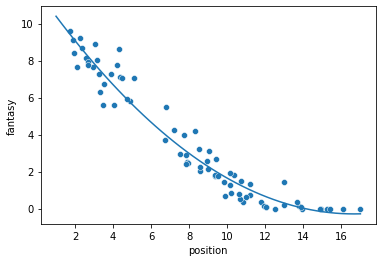

In [ ]:
sns.scatterplot(x='position', y='fantasy', data=result_df)
weights = np.polyfit(result_df['position'], result_df['fantasy'], 2)
model = np.poly1d(weights)
x = np.linspace(1, 17)
y = model(x)

y_pred = model(result_df['position'])

plt.plot(x, y)
plt.show()

From this relationship we can build a function to predict qualifying EV from mean race position.

In [ ]:
def qual_pts(pos):
    weights = np.polyfit(result_df['position'], result_df['fantasy'], 2)
    model = np.poly1d(weights)
    return max(model(pos), 0)

Next, let's do the same for modelling the probability of completing Q2 given a mean race position. A logistic relationship is clear in this case.

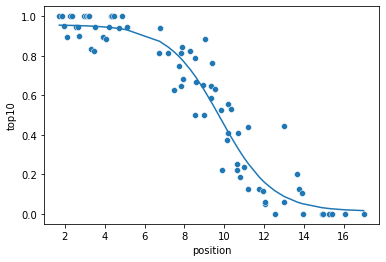

In [ ]:
result_df = result_df.sort_values(by='position')
sns.scatterplot(x=result_df['position'], y=result_df['top10'])

x = result_df['position'].to_numpy()
y = result_df['top10'].to_numpy()

def f(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

popt, pcov = optimize.curve_fit(f, x, y, method="trf")
y_fit = f(x, *popt)
plt.plot(x, y_fit, '-')
plt.show()

From this relationship, we can model the number of points expected from Q2 appearance.

In [ ]:
def q2_finish_pts(pos):
    x = result_df['position'].to_numpy()
    y = result_df['top10'].to_numpy()

    def f(x, a, b, c, d):
        return a / (1. + np.exp(-c * (x - d))) + b

    popt, pcov = optimize.curve_fit(f, x, y, method="trf")
    return f(pos, *popt) * 2

Next, let's look at Q3 finishes. We can use the same logistic regression model as a reasonable estimate.

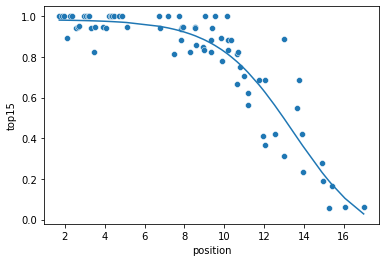

In [ ]:
result_df = result_df.sort_values(by='position')
sns.scatterplot(x=result_df['position'], y=result_df['top15'])

x = result_df['position'].to_numpy()
y = result_df['top15'].to_numpy()

def f(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

popt, pcov = optimize.curve_fit(f, x, y, method="trf")
y_fit = f(x, *popt)
plt.plot(x, y_fit, '-')
plt.show()

In [ ]:
def q3_finish_pts(pos):
    x = result_df['position'].to_numpy()
    y = result_df['top15'].to_numpy()

    def f(x, a, b, c, d):
        return a / (1. + np.exp(-c * (x - d))) + b

    popt, pcov = optimize.curve_fit(f, x, y, method="trf")
    return max(f(pos, *popt) * 3, 0)

Next, we want to look at modeling the relationship between expected race finish position and how many places one can be expected to gain in the race. A very loose but statistically significant correlation exists here.

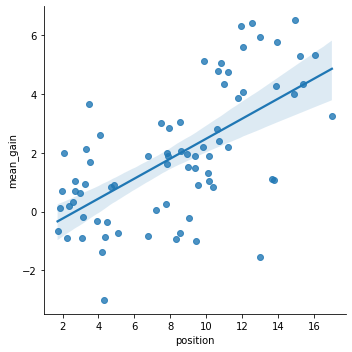

In [ ]:
sns.lmplot(x='position', y='mean_gain', data=result_df)
plt.show()

In [ ]:
def gain_pts(pos):  
    x, y = result_df['position'].values.reshape(-1, 1), result_df['mean_gain'].values.reshape(-1,1)
    reg = LinearRegression().fit(x, y)
    return reg.predict(np.array(pos).reshape(-1, 1))[0][0]

We can add the expected points from these new sources to $\texttt{ev_df}$

In [ ]:
ev_df['qual'] = [qual_pts(i) for i in pos_df['mean_pos']]
ev_df['gain'] = [gain_pts(i) for i in pos_df['mean_pos']]
ev_df['q'] = [q2_finish_pts(i) + q3_finish_pts(i) for i in pos_df['mean_pos']]
ev_df.head()

,race,flap,dnf,qual,gain,q
driver,,,,,,
Hamilton,11.115015,1.363521,-0.868960,5.511514,0.822270,4.769222
Verstappen,19.104632,1.721886,-0.981524,8.444103,-0.067157,4.845471
Russell,3.704475,0.585222,-1.295385,1.017342,2.881005,2.687805
Perez,11.520791,0.693624,-0.981524,5.417562,0.854129,4.763394
Ricciardo,1.629998,0.083370,-1.120488,0.000000,4.024401,0.910362


The next source of points to model is when drivers beat their teammates. Since we now have more data from this season to work from, we can use this to better effect than historical data. First we need to scrape this season's data:

In [ ]:
hrefs = [
    "1124/bahrain",
    # "1125/saudi-arabia"
]

qualifying_dfs, race_dfs, grid_dfs = [], [], []
season_length = 1 # Update after each race

# Collect qualifying, race and grid orders for this season's GPs
for href in hrefs[:season_length]:
    qualifying_url = f'https://www.formula1.com/en/results.html/2022/races/{href}/qualifying.html'
    qualifying_df = pd.read_html(qualifying_url)[0]
    # print(qualifying_df)
    qualifying_df['Driver'] = [unidecode.unidecode(name.split('  ')[1]) 
                               for name in qualifying_df['Driver']]
    qualifying_df['Driver'] = ['Zhou' if driver=='Guanyu' else driver for driver in qualifying_df['Driver']]
    qualifying_df['Driver'] = ['Vettel' if driver=='Hulkenberg' else driver for driver in qualifying_df['Driver']]
    qualifying_dfs.append(qualifying_df.set_index('Driver')[['Pos', 'Car', 'Q2', 'Q3']])
    # print(qualifying_df)
    
    race_url = f'https://www.formula1.com/en/results.html/2022/races/{href}.html'
    race_df = pd.read_html(race_url)[0]
    race_df['Driver'] = [unidecode.unidecode(name.split('  ')[1]) for name in race_df['Driver']]
    race_df['Driver'] = ['Zhou' if driver=='Guanyu' else driver for driver in race_df['Driver']]
    race_df['Driver'] = ['Vettel' if driver=='Hulkenberg' else driver for driver in race_df['Driver']]
    race_dfs.append(race_df.set_index('Driver')[['Pos', 'Car', 'Time/Retired']])
    
    grid_url = f'https://www.formula1.com/en/results.html/2022/races/{href}/starting-grid.html'
    grid_df = pd.read_html(grid_url)[0]
    grid_df['Driver'] = [unidecode.unidecode(name.split('  ')[1]) for name in grid_df['Driver']]
    # print(grid_df)
    grid_df['Driver'] = ['Zhou' if driver=='Guanyu' else driver for driver in grid_df['Driver']]
    grid_df['Driver'] = ['Vettel' if driver=='Hulkenberg' else driver for driver in grid_df['Driver']]
    print(grid_df['Driver'])
    grid_dfs.append(grid_df.set_index('Driver')[['Pos', 'Car']])

0        Leclerc
1     Verstappen
2          Sainz
3          Perez
4       Hamilton
5         Bottas
6      Magnussen
7         Alonso
8        Russell
9          Gasly
10          Ocon
11    Schumacher
12        Norris
13         Albon
14          Zhou
15       Tsunoda
16        Vettel
17     Ricciardo
18        Stroll
19        Latifi
Name: Driver, dtype: object


Next, we can use this data to see how often each driver beats their teammate, as well as their distribution of position gains and whether they tend to complete Q2 and Q3.

In [ ]:
drivers = race_dfs[0].index

event_df = pd.DataFrame(index=drivers)
event_df['team'] = race_dfs[0].Car
event_df['beat_teammate_race'] = np.empty((20, 0)).tolist()
event_df['beat_teammate_qualifying'] = np.empty((20, 0)).tolist()

event_df['position_gain'] = np.empty((20, 0)).tolist()
event_df['q2_finish'] = np.empty((20, 0)).tolist()
event_df['q3_finish'] = np.empty((20, 0)).tolist()



for i, (race_df, qualifying_df, grid_df) in enumerate(zip(race_dfs, qualifying_dfs, grid_dfs)):
    for team in race_df['Car'].unique():
        # Collect teammate race data
        team_df = race_df.loc[race_df['Car']==team]
        try:
            event_df.loc[team_df.index[0], 'beat_teammate_race'].append(1)
            event_df.loc[team_df.index[1], 'beat_teammate_race'].append(0)
        except IndexError:
            continue
        except KeyError:
            continue

        # Collect teammate qualifying data
        team_df = qualifying_df.loc[qualifying_df['Car']==team]
        try:
            event_df.loc[team_df.index[1], 'beat_teammate_qualifying'].append(0)
            event_df.loc[team_df.index[0], 'beat_teammate_qualifying'].append(1)
        except IndexError:
            continue

    for driver in drivers:
        # Collect position gain data
        if race_df.loc[driver, 'Pos'] == 'NC':
            gain = 0
        elif race_df.loc[driver, 'Time/Retired'] in ['DNF', 'DNS']:
            gain = 0
        else:
            try:
                gain = int(grid_df.loc[driver, 'Pos']) - int(race_df.loc[driver, 'Pos'])
            except KeyError:
                gain = 20 - int(race_df.loc[driver, 'Pos'])
            except ValueError:
                gain = 0
        event_df.loc[driver, 'position_gain'].append(gain)
        
        # Collect Q2 qualification data
        try:
            if pd.isnull(qualifying_df.loc[driver, 'Q2']):
                event_df.loc[driver, 'q2_finish'].append(0)
            else:
                event_df.loc[driver, 'q2_finish'].append(1)
        except KeyError:
            event_df.loc[driver, 'q2_finish'].append(0)
        
        # Collect Q3 qualification data
        try:
            if pd.isnull(qualifying_df.loc[driver, 'Q3']):
                event_df.loc[driver, 'q3_finish'].append(0)
            else:
                event_df.loc[driver, 'q3_finish'].append(1)
        except KeyError:
            event_df.loc[driver, 'q3_finish'].append(0)

# We must normalise each probability towards mean to account for sample noise
event_df['P(beat_teammate_race)'] = [np.mean(l) for l in event_df['beat_teammate_race']]
event_df['P(beat_teammate_race)'] = (5 * event_df['P(beat_teammate_race)'] + 0.5) / 6
event_df['P(beat_teammate_qualifying)'] = [np.mean(l) for l in event_df['beat_teammate_qualifying']]
event_df['P(beat_teammate_qualifying)'] = (5 * event_df['P(beat_teammate_qualifying)'] + 0.5) / 6
event_df = pd.DataFrame(event_df[['team', 'P(beat_teammate_race)', 'P(beat_teammate_qualifying)']])
event_df.head()

,team,P(beat_teammate_race),P(beat_teammate_qualifying)
Driver,,,
Leclerc,Ferrari,0.916667,0.916667
Sainz,Ferrari,0.083333,0.083333
Hamilton,Mercedes,0.916667,0.916667
Russell,Mercedes,0.083333,0.083333
Magnussen,Haas Ferrari,0.916667,0.916667


Finally, we must adjust the beating teammate probabilities to take into account the events that either (or both) drivers in each team are not classified in the race:

In [ ]:
for team in event_df.team.unique():
    drivers = event_df[event_df['team']==team].index.tolist()
    print(drivers)
    p_no_dnf = (1 - df.loc[drivers[0], 'dnf']) * (1 - df.loc[drivers[1], 'dnf'])
    
    adjusted = adjust_odds(np.array(event_df.loc[drivers, 'P(beat_teammate_race)']), p_no_dnf, method='linear')
    event_df.loc[drivers, 'P(beat_teammate_race)'] = adjusted
    
    event_df.loc[drivers[0], 'P(beat_teammate_race)'] += (1 - df.loc[drivers[0], 'dnf']) * df.loc[drivers[1], 'dnf']
    event_df.loc[drivers[1], 'P(beat_teammate_race)'] += (1 - df.loc[drivers[1], 'dnf']) * df.loc[drivers[0], 'dnf']
    
event_df.head()

['Leclerc', 'Sainz']
['Hamilton', 'Russell']
['Magnussen', 'Schumacher']
['Bottas', 'Zhou']
['Ocon', 'Alonso']
['Tsunoda', 'Gasly']
['Stroll', 'Vettel']
['Albon', 'Latifi']
['Ricciardo', 'Norris']
['Perez', 'Verstappen']


,team,P(beat_teammate_race),P(beat_teammate_qualifying)
Driver,,,
Leclerc,Ferrari,0.842486,0.916667
Sainz,Ferrari,0.151863,0.083333
Hamilton,Mercedes,0.870343,0.916667
Russell,Mercedes,0.124654,0.083333
Magnussen,Haas Ferrari,0.800255,0.916667


In [ ]:
for driver in df.index:
    ev_df.loc[driver, 'beat_teammate'] = event_df.loc[driver, 'P(beat_teammate_race)'] * 3 \
                                        + event_df.loc[driver, 'P(beat_teammate_qualifying)'] * 2

The last source of Fantasy F1 points we need to model is streaks - drivers get 5 points for a qualifying streak and 10 points for a race streak.

In [ ]:
q_streak_drivers = []
race_streak_drivers = []

In [ ]:
for driver in pos_df.index:
    if driver in q_streak_drivers:
        streak_prob = q3_finish_pts(pos_df.loc[driver, 'mean_pos']) / 3
        ev_df.loc[driver, 'q_streak'] = streak_prob * 5
    else:
        ev_df.loc[driver, 'q_streak'] = 0

for driver in pos_df.index:
    if driver in race_streak_drivers:
        streak_prob = sum([pos_df.loc[driver, i] for i in range(1,11)])
        ev_df.loc[driver, 'race_streak'] = streak_prob * 10
    else:
        ev_df.loc[driver, 'race_streak'] = 0
        
ev_df

,race,flap,dnf,qual,gain,q,beat_teammate,q_streak,race_streak
driver,,,,,,,,,
Hamilton,11.115015,1.363521,-0.868960,5.511514,0.822270,4.769222,4.444363,0.0,0.0
Verstappen,19.104632,1.721886,-0.981524,8.444103,-0.067157,4.845471,2.235146,0.0,0.0
Russell,3.704475,0.585222,-1.295385,1.017342,2.881005,2.687805,0.540628,0.0,0.0
Perez,11.520791,0.693624,-0.981524,5.417562,0.854129,4.763394,2.752009,0.0,0.0
Ricciardo,1.629998,0.083370,-1.120488,0.000000,4.024401,0.910362,2.728524,0.0,0.0
Leclerc,15.421268,0.194649,-1.295385,6.853594,0.392587,4.821357,4.360792,0.0,0.0
Vettel,1.651994,0.011312,-1.295385,0.000000,4.026006,0.908300,2.278722,0.0,0.0
Alonso,4.142765,0.011312,-1.120488,2.321284,2.111973,3.941196,2.284406,0.0,0.0
Sainz,12.935471,0.102481,-0.981524,5.397598,0.860932,4.762104,0.622255,0.0,0.0


And those are all the point sources for drivers! Let's compile this into a new DataFrame to review:

In [ ]:
driver_df = pd.DataFrame(ev_df.T.sum(), columns=['EV'])
driver_df.sort_values(by='EV', ascending=False)

,EV
driver,
Verstappen,35.302557
Leclerc,30.748862
Hamilton,27.156945
Perez,25.019985
Sainz,23.699318
Gasly,20.864529
Bottas,20.432532
Magnussen,14.094489
Alonso,13.692447


Next, let's add up the current points projections for constructors:

In [ ]:
team_df = pd.DataFrame(index=pos_df['team'].unique().tolist())

for team in pos_df['team'].unique():
    t_df = ev_df[pos_df['team']==team]
    team_df.loc[team, 'EV'] = t_df['race'].sum() + t_df['qual'].sum() + t_df['q'].sum() + t_df['gain'].sum() 
team_df.sort_values(by='EV', ascending=False)

,EV
Red Bull,54.882926
Ferrari,51.444911
Mercedes,32.508647
Alphatauri,26.258879
Alfa Romeo,23.942765
Alpine,21.068871
Haas,20.645891
Williams,15.094602
Aston Martin,14.591293
McLaren,13.800604


Constructors also get 5 points if both of their drivers get streaks in qualifying and 10 in race. We can work out the probability of this happening with the values from $\texttt{pos_df}$.

In [ ]:
q_streak_teams = []
race_streak_teams = []

In [ ]:
for team in q_streak_teams:
    drivers = pos_df[pos_df['team']==team].index.tolist()
    streak_prob = q3_finish_pts(pos_df.loc[drivers[0], 'mean_pos']) / 3 * q3_finish_pts(pos_df.loc[drivers[1], 'mean_pos']) / 3
    team_df.loc[team, 'EV'] += streak_prob * 5

for team in race_streak_teams:
    drivers = pos_df[pos_df['team']==team].index.tolist()
    streak_prob = sum([pos_df.loc[drivers[0], i] for i in range(1,11)]) * sum([pos_df.loc[drivers[1], i] for i in range(1,11)])
    team_df.loc[team, 'EV'] += streak_prob * 10

team_df.sort_values(by='EV', ascending=False)

,EV
Red Bull,54.882926
Ferrari,51.444911
Mercedes,32.508647
Alphatauri,26.258879
Alfa Romeo,23.942765
Alpine,21.068871
Haas,20.645891
Williams,15.094602
Aston Martin,14.591293
McLaren,13.800604


## Optimising EV Projections

Now we move onto the last part of the model - using these EV projections to optimise teams.

To do this, we need to get the prices of each driver and constructor.

In [ ]:
driver_prices = {
    'Hamilton': 31.0,
    'Verstappen': 30.5,
    'Perez': 17.5,
    'Bottas': 23.3,
    'Norris': 16.0,
    'Leclerc': 18.0,
    'Gasly': 13.5,
    'Ricciardo': 14.5,
    'Sainz': 17.0,
    'Tsunoda': 8.2,
    'Alonso': 12.5,
    'Stroll': 13.2,
    'Vettel': 11.5,
    'Ocon': 12.5,
    'Russell': 24.0,
    'Zhou': 8.0,
    'Albon': 7.5,
    'Latifi': 7.0,
    'Schumacher': 6.5,
    'Magnussen': 5.5,
}

team_prices = {
    'Mercedes': 34.5,
    'Red Bull': 32.5,
    'McLaren': 18.5,
    'Ferrari': 25.0,
    'Alphatauri': 10.5,
    'Aston Martin': 11.5,
    'Alpine': 14,
    'Alfa Romeo': 8,
    'Williams': 7,
    'Haas': 6
}

for i in driver_prices:
    driver_df.loc[i, 'price'] = driver_prices[i]

for i in team_prices:
    team_df.loc[i, 'price'] = team_prices[i]

In [ ]:
pd.concat([team_df.sort_values(by='EV', ascending=False), driver_df.sort_values(by='EV', ascending=False)])

,EV,price
Red Bull,54.882926,32.5
Ferrari,51.444911,25.0
Mercedes,32.508647,34.5
Alphatauri,26.258879,10.5
Alfa Romeo,23.942765,8.0
Alpine,21.068871,14.0
Haas,20.645891,6.0
Williams,15.094602,7.0
Aston Martin,14.591293,11.5
McLaren,13.800604,18.5


In [ ]:
driver_df.sort_values(by='EV', ascending=False)

,EV,price
driver,,
Verstappen,35.302557,30.5
Leclerc,30.748862,18.0
Hamilton,27.156945,31.0
Perez,25.019985,17.5
Sainz,23.699318,17.0
Gasly,20.864529,13.5
Bottas,20.432532,23.3
Magnussen,14.094489,5.5
Alonso,13.692447,12.5


At last we are ready to construct a linear optimisation model!

In [ ]:
def solve_team(budget, owned_drivers, owned_team, force_include, force_exclude, transfers=3):
    # Turn owned_drivers and owned_team into an array for linear programming
    owned_drivers = {d: 0 + int(d in owned_drivers) for d in driver_df.index}
    owned_team = {c: 0 + int(c == owned_team) for c in team_df.index}

    # Initialise optimisation problem and set up decision variables
    prob = LpProblem("F1_model", LpMaximize)
    drivers = LpVariable.dicts('drivers', driver_df.index, cat='Binary')
    teams = LpVariable.dicts('teams', team_df.index, cat='Binary')
    turbo = LpVariable.dicts('turbo', driver_df.index, cat='Binary')

    # Set objective function
    prob += lpSum([drivers[d] * driver_df.loc[d, 'EV'] for d in drivers]) \
            + lpSum([teams[t] * team_df.loc[t, 'EV'] for t in teams]) \
            + lpSum([turbo[d] * driver_df.loc[d, 'EV'] for d in drivers])

    # Constrain number of drivers to 5, and number of teams and turbo drivers to 1
    prob += lpSum(drivers) == 5
    prob += lpSum(teams) == 1
    prob += lpSum(turbo) == 1
    
    # Total price of assets must be less than or equal to total budget
    prob += lpSum([drivers[d] * driver_df.loc[d, 'price'] for d in drivers]) + \
            lpSum([teams[t] * team_df.loc[t, 'price'] for t in teams]) <= budget

    # Turbo driver must cost at most 19.9
    prob += lpSum([turbo[d] * driver_df.loc[d, 'price'] for d in drivers]) <= 19.9
    for d in drivers:
        prob += turbo[d] <= drivers[d]
    
    # The total number of assets kept the same must be at least 6 minus the number of available transfers
    prob += lpSum([owned_drivers[d] * drivers[d] for d in drivers]) \
                + lpSum([owned_team[t] * teams[t] for t in teams]) >= 6 - transfers

    # Force the inclusion and exclusion of given drivers and teams
    for d in force_include['driver']:
        prob += drivers[d] == 1
    for t in force_include['team']:
        prob += teams[t] == 1
    for d in force_exclude['driver']:
        prob += drivers[d] == 0
    for t in force_exclude['team']:
        prob += team[t] == 0
    
    # We can expect Schumacher to outscore Latifi & Russell
    for d in ['Latifi']:
        prob += drivers[d] <= drivers['Schumacher']

    # Solve problem and return optimal decision variables and objective value
    status = prob.solve()
    return {
        'drivers': sorted([d for d in drivers if drivers[d].varValue == 1], key=lambda x: -driver_prices[x]),
        'team': [t for t in teams if teams[t].varValue == 1][0],
        'turbo driver': [d for d in drivers if turbo[d].varValue == 1][0],
        'EV': value(prob.objective)
    }

Let's solve the problem for my team this week!

In [ ]:
print(
    solve_team(
        budget=100,
        owned_drivers=['Leclerc', 'Sainz', 'Perez', 'Bottas', 'Magnussen'],
        owned_team='Red Bull',
        force_include={'driver': [], 'team': []},
        force_exclude={'driver': [], 'team': []},
        transfers=3,
    )
)

{'drivers': ['Leclerc', 'Perez', 'Sainz', 'Gasly', 'Magnussen'], 'team': 'Ferrari', 'turbo driver': 'Leclerc', 'EV': 196.62095506687294}


Over a range of different prices, here are the optimal solutions:

In [ ]:
optimal_teams = {}

min_budget, max_budget = 90, 100
last_team = {}
b = min_budget
while b <= max_budget:
    b = round(b, 1)
    team = solve_team(
                budget=b,
                owned_drivers=[],
                owned_team='',
                force_include={'driver': [], 'team': []},
                force_exclude={'driver': [], 'team': []},
                transfers=12
                )
    if team != last_team:
        optimal_teams[b] = team
    last_team = team
    b += 0.1

out_df = pd.DataFrame(optimal_teams).T
for i in range(5):
    out_df[f'driver {i+1}'] = [d[i] for d in out_df['drivers']]
out_df.index = [f'{out_df.index[i-1]}-{round(out_df.index[i] - 0.1, 1)}' 
                for i in range(1, len(out_df))] + [f'{out_df.index[-1]}-{max_budget}']
out_df.index.name = 'budget range'
out_df.drop('drivers', axis=1)[['driver 1', 'driver 2', 'driver 3', 'driver 4', 'driver 5', 
                                'turbo driver', 'team', 'EV']]

,driver 1,driver 2,driver 3,driver 4,driver 5,turbo driver,team,EV
budget range,,,,,,,,
90.0-90.4,Leclerc,Perez,Gasly,Albon,Magnussen,Leclerc,Ferrari,184.338964
90.5-94.4,Leclerc,Perez,Sainz,Albon,Magnussen,Leclerc,Ferrari,187.173753
94.5-95.4,Leclerc,Perez,Gasly,Albon,Magnussen,Leclerc,Red Bull,187.776979
95.5-96.4,Leclerc,Perez,Sainz,Alonso,Magnussen,Leclerc,Ferrari,189.448874
96.5-100,Leclerc,Perez,Sainz,Gasly,Magnussen,Leclerc,Ferrari,196.620955


The accuracy of the model is difficult to test. Fantasy F1 is extremely high-variance, and there is no data available to back-test. There is also no hindsight metric available to reduce noise, such as xG can be used for football. Initial results are positive though; so far this season I am in the top 2.5% of players, despite lacking anything beyond a very novice knowledge of F1.